### User settings

In [6]:
data_path = "./data/"

### Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from thermopot import materials, calculations, reactions, potentials, potential 

### Read in data and build materials

If xc-functional is not defined in variable name, assume SCAN.

In [8]:
# Ba-S system ground state energies
Ba_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/Ba_Im-3m/scan/aims.out")
BaS_calc = calculations.AimsCalculation(data_path+"raw_aims_files/binary/BaS_Fm-3m/scan/aims.out")
BaS2_calc  = calculations.AimsCalculation(data_path+"raw_aims_files/binary/BaS2_C2_c/scan/aims.out")
BaS3_P4_calc = calculations.AimsCalculation(data_path+"raw_aims_files/binary/BaS3_P-421m/scan/aims.out")
BaS3_P2_calc = calculations.AimsCalculation(data_path+"raw_aims_files/binary/BaS3_P2_12_12/scan/aims.out")
Ba2S3_calc = calculations.AimsCalculation(data_path+"raw_aims_files/binary/Ba2S3_I4_1md/scan/aims.out")

# alpha-sulfur (solid) ground state energy
S_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/S_P2_c/scan/aims.out")

# S2 gas ground state energy
S2_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/S2/scan/aims.out",gas=True)

# S8 gas ground state energy
S8_calc = calculations.AimsCalculation(data_path+"raw_aims_files/elemental/S8/scan/aims.out",gas=True)

In [9]:
Ba = materials.Solid("Ba",{"Ba": 1},data_path+"phonopy_output/Ba_Im-3m.dat",calculation=Ba_calc)
BaS = materials.Solid("BaS", {"Ba":1, "S": 1},data_path+"phonopy_output/BaS_Fm-3m.dat",calculation=BaS_calc)
BaS2 = materials.Solid("BaS2", {"Ba":1, "S": 2},data_path+"phonopy_output/BaS2_C2_c.dat",calculation=BaS2_calc)
BaS3_P4 = materials.Solid("BaS3", {"Ba":1, "S": 3},data_path+"phonopy_output/BaS3_P-421m.dat",calculation=BaS3_P4_calc)
BaS3_P2 = materials.Solid("BaS3_P2", {"Ba":1, "S": 3},data_path+"phonopy_output/BaS3_P2_12_12.dat",calculation=BaS3_P2_calc)
Ba2S3 = materials.Solid("Ba2S3", {"Ba":2, "S": 3},data_path+"phonopy_output/Ba2S3_I4_1md.dat",calculation=Ba2S3_calc)

S =  materials.Solid("S",{"S":1},data_path+"phonopy_output/S_adam.dat",calculation=S_calc)
S2 = materials.IdealGas("S2",{'S':2},data_path+"nist_janaf/S2.dat",calculation=S2_calc,zpe_lit=0.0893)   # from CCCBDB
S8 = materials.IdealGas("S8",{'S':8},data_path+"nist_janaf/S8.dat",calculation=S8_calc,zpe_lit=0.335)  # from CCCBDB

### Define temperature and pressure range

The Sulfur model is only valid for 400-1500K and 10^0-10^7 Pascal.

In [10]:
T = np.linspace(400,1500,1000) # K
P = np.array( np.logspace(1,7,1000),ndmin=2).transpose() # Pa   valid region for sulfur mode

# S2 total energy using S8 as a reference

Instead of using a SCAN calculated total energy for the S2 allotrope, we reference it to the S8 allotrope using the energy difference reported in Adam's paper (https://doi.org/10.1039/C5SC03088A). This is a workaround for the fact that the difference in energy calculated at SCAN level of theory is too large.

In [11]:
eV_to_kJpermole = 96.485

delta_S2_S8_from_Jackson_model = 50 # in kJ per mole
delta_S2_S8_from_Jackson_model_eV = delta_S2_S8_from_Jackson_model*(1/eV_to_kJpermole) 
print(delta_S2_S8_from_Jackson_model_eV)
# this is energy difference between S2 and S8, per atom (in eV)

0.5182152666217547


In [12]:
S2_energy_referenced_to_S8 = ((S8_calc.energy/8) + delta_S2_S8_from_Jackson_model_eV)*2
# the factors of 8 and 2 are due to stoichiometry of systems

In [13]:
# create calculation object using this updated energy
S2_calc_referenced_to_S8 = calculations.Calculation(energy=S2_energy_referenced_to_S8,xc='scan',NAtoms=2)
# create material using updated calculation
S2_referenced_to_S8 = materials.IdealGas("S2",{'S':2},data_path+"nist_janaf/S2.dat",calculation=S2_calc_referenced_to_S8,zpe_lit=0.0893)   # from CCCBDB

Text(0.5, 0, 'K')

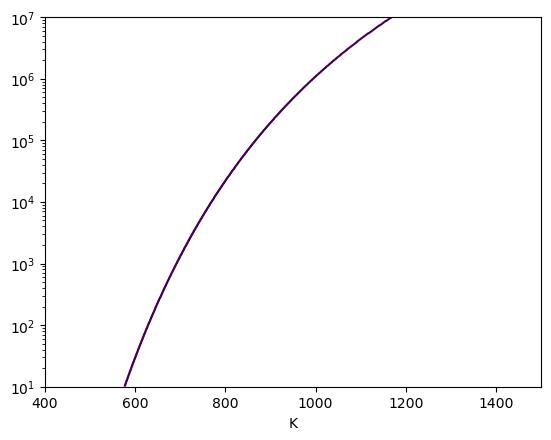

In [14]:
# compare formation energy of S2 and S8
S2_formation = reactions.Reaction({},{S2_referenced_to_S8:1},temperature=T,pressure=P)
S2_mu = S2_formation.Dmu(xc='scan',units="kJ")

S8_formation = reactions.Reaction({},{S8:1},temperature=T,pressure=P)
S8_mu = S8_formation.Dmu(xc='scan',units="kJ")

# plot line where chemical potential of S2 (which dominates at higher T / lower P) 
# is equal to chemical potential of S8 (which dominates at lower T / higher P)
plt.contour(T,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])
plt.yscale('log')
plt.xlabel("K")

As expected, this reproduces the line where the chemical potential of S8 is equal to the chemical potential of S2.

# Referencing the sulfur vapour model to experimental data

In our paper, the parameterised sulfur model published by Adam (see paper linked above) was referenced to the S8 vapour total energy calculated using SCAN. This is to allow comparison with other total energies (for Ba, BaS etc...) also calculated at this level of theory. However SCAN was developed for solid state materials (see e.g. https://arxiv.org/pdf/1511.01089.pdf), and so this energy might be deemed more unreliable compared to those calculated using SCAN for the solid state materials.

A work-around is to reference the parameterised sulfur model to the SCAN-calculated value for sulfur in the solid state (alpha-sulfur). Here we use the experimentally measured change in enthalpy $H$ when solid sulfur sublimates to form sulfur gas:

$\Delta H_{sub} = (H_8/8) - H_{alpha} = 12.552$ kJ/mol.

This experimentally measured value is for experiments at 298 K and 1bar (from NIST-JANAF data). It is reported on a per-atom basis.

In [15]:
calculated_H_sub = (S8.H(T=298,xc='scan')/8 - S.H(T=298,P=1E5,xc='scan'))*eV_to_kJpermole
# note that `H` is returned per formula, so S8.H is for 8 atoms, whereas S.H is for a single atom

# our calculated enthalpy of sublimation, about half that measured experimentally
print(calculated_H_sub)

5.442733959694469


In [16]:
experimental_H_sub = 12.552
energy_shift_eV = (experimental_H_sub - calculated_H_sub) / eV_to_kJpermole
# this is the shift in S8 total energy required so that the calculated energy of sublimation is equal to that
# found experimentally.
print(energy_shift_eV)

0.07368260393123834


In [17]:
# create a sulfur model object with this energy shift
S_g_referenced_to_experiment = materials.Sulfur_model(S8_calc.energy/8+energy_shift_eV)  

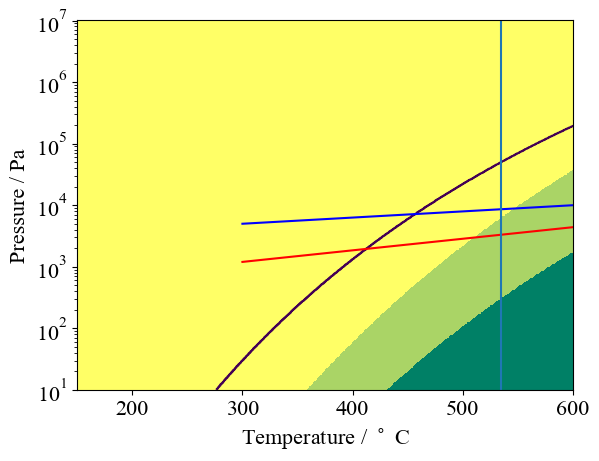

In [18]:
# create phase diagram
BaS_reaction = reactions.Reaction({Ba:8,S_g_referenced_to_experiment:24},{BaS:8,S_g_referenced_to_experiment:16},temperature=T,pressure=P,fu=8)
BaS2_reaction = reactions.Reaction({Ba:8,S_g_referenced_to_experiment:24},{BaS2:8,S_g_referenced_to_experiment:8},temperature=T,pressure=P,fu=8)
BaS3_reaction = reactions.Reaction({Ba:8,S_g_referenced_to_experiment:24},{BaS3_P4:8},temperature=T,pressure=P,fu=8)
BaS3_P2_reaction = reactions.Reaction({Ba:8,S_g_referenced_to_experiment:24},{BaS3_P2:8},temperature=T,pressure=P,fu=8)
Ba2S3_reaction = reactions.Reaction({Ba:8, S_g_referenced_to_experiment:3}, {Ba2S3:4, S_g_referenced_to_experiment:12}, temperature=T, pressure=P, fu=8)
BaS_system = potentials.Potentials(BaS_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS2_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS3_reaction.Dmu(units="kJ",xc='scan',T=T,P=P))
plt = BaS_system.plot_TvsP(material_labels=["BaS","BaS2","BaS3","BaS3_P2"],log_scale=True,T_units="C")
# overlay the division line between S2 and S8 dominated regions
plt.contour(T-300,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])
# plot across valid region
plt.xlim([150,600])
# overlay calcs from ideal gas
plt.plot([300,600],[5E3,1E4],color='b',label='S8')
plt.plot([300,600],[1.2E3,4.4E3],color='r',label='S2')
# overlay highest temperature at which BaS3 detected
plt.vlines(x=535,ymin = 1E1,ymax=1E7)
plt.show()

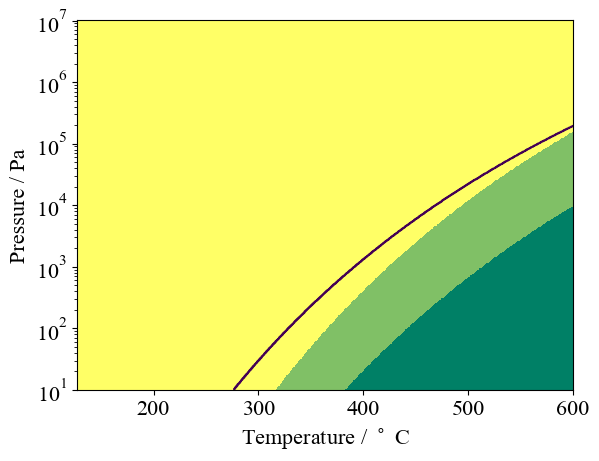

In [21]:

# create calculation object using this updated energy
S2_calc_referenced_to_S8_exp = calculations.Calculation(energy=S2_energy_referenced_to_S8+2*energy_shift_eV,xc='scan',NAtoms=2)
# create material using updated calculation
S2_referenced_to_S8_exp = materials.IdealGas("S2",{'S':2},data_path+"nist_janaf/S2.dat",calculation=S2_calc_referenced_to_S8_exp,zpe_lit=0.0893)   # from CCCBDB
# the factors of 8 and 2 are due to stoichiometry of systems


Ba2S3_reaction = reactions.Reaction({Ba:4,S2_referenced_to_S8_exp:6},{Ba2S3:1, S2_referenced_to_S8_exp:1.5},temperature=T, pressure=P, fu=4)
BaS_reaction = reactions.Reaction({Ba:4,S2_referenced_to_S8_exp:6},{BaS:4,S2_referenced_to_S8_exp:4},temperature=T,pressure=P,fu=4)
BaS2_reaction = reactions.Reaction({Ba:4,S2_referenced_to_S8_exp:6},{BaS2:4,S2_referenced_to_S8_exp:2},temperature=T,pressure=P,fu=4)
BaS3_reaction = reactions.Reaction({Ba:4,S2_referenced_to_S8_exp:6},{BaS3_P4:4},temperature=T,pressure=P,fu=4)
BaS3_P2_reaction = reactions.Reaction({Ba:4,S2_referenced_to_S8_exp:6},{BaS3_P2:4},temperature=T,pressure=P,fu=4)

BaS_system = potentials.Potentials(Ba2S3_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS2_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS3_reaction.Dmu(units="kJ",xc='scan',T=T,P=P),BaS3_P2_reaction.Dmu(units="kJ",xc='scan',T=T,P=P))
plt = BaS_system.plot_TvsP(material_labels=["BaS","BaS2","BaS3"],log_scale=True,T_units="C")
plt.xlim(127,600)
#plt.savefig("r_Ba_S_stability_S2")


plt.contour(T-300,P.flatten(),S8_mu.potential <= S2_mu.potential*4, levels=[.5])